In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices()
tf.config.experimental.set_memory_growth(physical_devices[3], True)
from tensorflow_addons.optimizers import ExponentialCyclicalLearningRate

In [2]:
import os

AUTOTUNE  = tf.data.experimental.AUTOTUNE
import numpy as np
import matplotlib.pyplot as plt
from labels import labels
from efficientv5 import get_model
from tensorflow.keras.models import Model

 Number of Visible GPU is 1 
Growth Allowed
STEP 1
AFTER MODEL


In [3]:
import wandb
from wandb.keras import WandbCallback


In [4]:
run = wandb.init(project  = "trial-9",
                 config = {
                     "learning_rate" : "cyclical_lr_(0.1_to_1e-7)",
                    "loss_function": "categorical_ce-log(dice_coeff+epsilon) ",
                    "architecture": "EffiecientNetB7_with_atrous_conv",
                    "dataset": "BDD100K"
                })
config = wandb.config

wandb: Currently logged in as: hgautam23 (use `wandb login --relogin` to force relogin)
/home/himanshu/anaconda3/envs/project/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
os.getcwd()

'/home/himanshu/Github/Semantic Segmentation'

In [6]:
images_dir = str(os.getcwd()) + "/images/"
label_dir =str(os.getcwd()) + "/labels/"
IMAGE_HEIGHT = 288
IMAGE_WIDTH = 512
BATCH_SIZE = 4
NUM_EPOCHS = 300

In [7]:
mask_info = [(label.name, label.color, label.id) for label in labels]
mask_pallete = [label.color for label in labels]
accepted_Id = []
ignored_Id = []
accepted_color = []
ignored_color = []
for label in labels:
    if label.ignoreInEval == False:
        accepted_Id.append(label.id)
        accepted_color.append(label.color)
    else:
        ignored_Id.append(label.id)
        accepted_color.append(label.color)
        
trainId = [1, 2, 6, 9, 15, 16, 29, 30] + accepted_Id
mask_pallete = ignored_color+ accepted_color 

NUM_CLASSES = len(np.unique(trainId))
print(NUM_CLASSES)
           

27


In [8]:
mask_info

[('unlabeled', (0, 0, 0), 0),
 ('ego vehicle', (0, 0, 0), 1),
 ('rectification border', (0, 0, 0), 2),
 ('out of roi', (0, 0, 0), 3),
 ('static', (0, 0, 0), 4),
 ('dynamic', (111, 74, 0), 5),
 ('ground', (81, 0, 81), 6),
 ('road', (128, 64, 128), 7),
 ('sidewalk', (244, 35, 232), 8),
 ('parking', (250, 170, 160), 9),
 ('rail track', (230, 150, 140), 10),
 ('building', (70, 70, 70), 11),
 ('wall', (102, 102, 156), 12),
 ('fence', (190, 153, 153), 13),
 ('guard rail', (180, 165, 180), 14),
 ('bridge', (150, 100, 100), 15),
 ('tunnel', (150, 120, 90), 16),
 ('pole', (153, 153, 153), 17),
 ('polegroup', (153, 153, 153), 18),
 ('traffic light', (250, 170, 30), 19),
 ('traffic sign', (220, 220, 0), 20),
 ('vegetation', (107, 142, 35), 21),
 ('terrain', (152, 251, 152), 22),
 ('sky', (70, 130, 180), 23),
 ('person', (220, 20, 60), 24),
 ('rider', (255, 0, 0), 25),
 ('car', (0, 0, 142), 26),
 ('truck', (0, 0, 70), 27),
 ('bus', (0, 60, 100), 28),
 ('caravan', (0, 0, 90), 29),
 ('trailer', (0, 

In [9]:
print(ignored_Id)
print(accepted_Id)
print(trainId[:])
weights = [0.7, 0.7, 0.7, 0.7, 1.0, 0.7, 0.7, 0.8, 0.8, 0.7, 0.8, 0.8, 0.8,  0.8, 1.2, 1.2, 1.2, 1.0, 1.0, 0.8, 1.4, 1.4, 1.1, 1.0, 1.0, 1.0, 1.3, 1.3]
# for i in range(len(trainId)):
#     print(trainId[i], weights[i])
tf.nn.softmax(weights, axis = -1)

[0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
[7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
[1, 2, 6, 9, 15, 16, 29, 30, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]


<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([0.0270672 , 0.0270672 , 0.0270672 , 0.0270672 , 0.0365369 ,
       0.0270672 , 0.0270672 , 0.02991388, 0.02991388, 0.0270672 ,
       0.02991388, 0.02991388, 0.02991388, 0.02991388, 0.04462628,
       0.04462628, 0.04462628, 0.0365369 , 0.0365369 , 0.02991388,
       0.05450665, 0.05450665, 0.04037952, 0.0365369 , 0.0365369 ,
       0.0365369 , 0.04931966, 0.04931966], dtype=float32)>

In [10]:
train_label_dirs = []
val_label_dirs = []
dirs = []

for (dirpath, dirname, filenames) in os.walk(str(label_dir +"train")):

    for name in filenames:
        if name[-12:] == 'labelIds.png':
            train_label_dirs.append(os.path.join(dirpath, name))
            
train_label_dirs = sorted(train_label_dirs)            
            
print(f"Train Directory contains {len(train_label_dirs)} labels")        
        
for (dirpath, dirname, filenames) in os.walk(str(label_dir +"val")):
    for name in filenames:
        if name[-12:] == 'labelIds.png':
            val_label_dirs.append(os.path.join(dirpath, name))

val_label_dirs = sorted(val_label_dirs)
print(f"Val Directory contains {len(val_label_dirs)} labels")        
    


Train Directory contains 2975 labels
Val Directory contains 500 labels


In [11]:

train_images_dir_list = tf.data.Dataset.list_files(str(images_dir)+ "train/*/*", shuffle = False)
train_labels_dir_list = tf.data.Dataset.from_tensor_slices(train_label_dirs)





val_images_dir_list = tf.data.Dataset.list_files(str(images_dir)+ "val/*/*", shuffle = False)
val_labels_dir_list = tf.data.Dataset.from_tensor_slices(val_label_dirs)



In [11]:

# train_images_dir_list = train_images_dir_list.take(TRAIN_SAMPLES)
# train_labels_dir_list = train_labels_dir_list.take(TRAIN_SAMPLES)


# val_images_dir_list = val_images_dir_list.take(VAL_SAMPLES)
# val_labels_dir_list = val_labels_dir_list.take(VAL_SAMPLES)


train_images_dir_list = train_images_dir_list
train_labels_dir_list = train_labels_dir_list


val_images_dir_list = val_images_dir_list
val_labels_dir_list = val_labels_dir_list


In [12]:
train_ds  = tf.data.Dataset.zip((train_images_dir_list, train_labels_dir_list))

val_ds = tf.data.Dataset.zip((val_images_dir_list, val_labels_dir_list))

print(f"TRAIN DATASET CONTAINS {len(train_ds)} SAMPLES")
print(f"VALIDATION DATASET CONTAINS {len(val_ds)} SAMPLES")


TRAIN DATASET CONTAINS 2975 SAMPLES
VALIDATION DATASET CONTAINS 500 SAMPLES


In [13]:
def decode_img(img):
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method = "nearest")
    img = tf.cast(img, dtype = tf.float32)
    img = img/255.0
    
    return img

In [14]:
def decode_color_mask(mask):
    mask = tf.image.decode_png(mask, channels = 1)
    mask = tf.image.resize(mask, [IMAGE_HEIGHT, IMAGE_WIDTH], method= "nearest")
    

    binary = tf.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype = tf.uint8) 
    for i in trainId: 
        binary = tf.keras.backend.concatenate([binary,(tf.cast(mask == i, dtype = tf.uint8))], axis = -1)

    return binary[:,:,1:]
    

In [15]:
def process_path(image_dir, mask_dir):
    img = tf.io.read_file(image_dir)
    mask = tf.io.read_file(mask_dir)
    img = decode_img(img)
    mask = decode_color_mask(mask)

    return img, mask


In [16]:
train_ds = train_ds.map(process_path, AUTOTUNE)
val_ds = val_ds.map(process_path, AUTOTUNE)


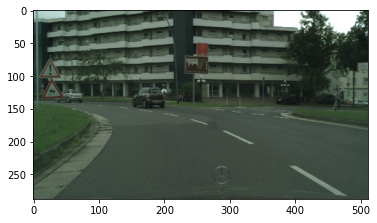

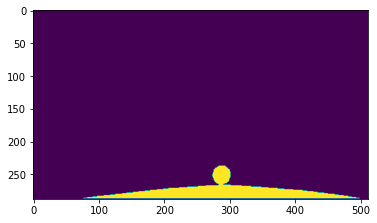

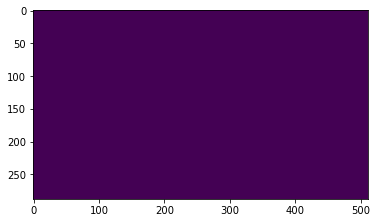

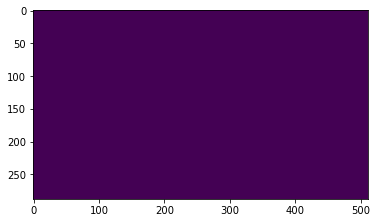

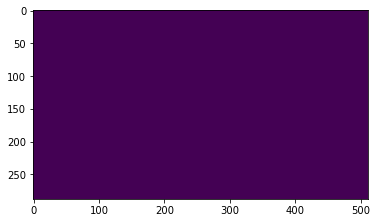

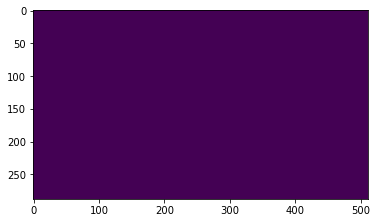

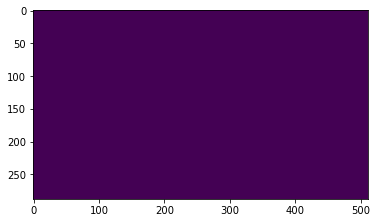

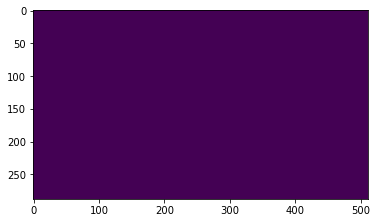

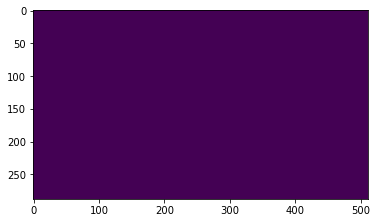

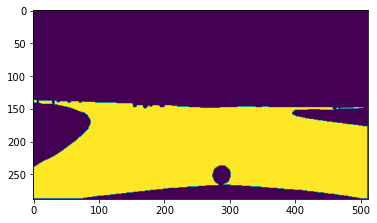

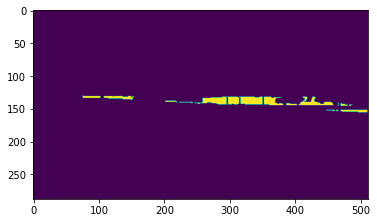

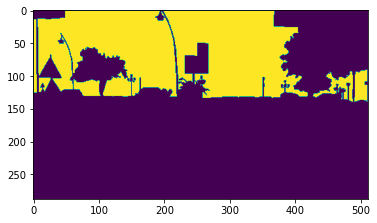

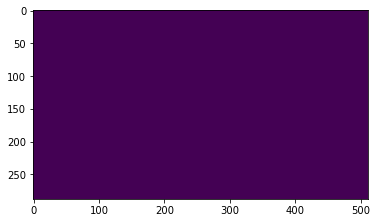

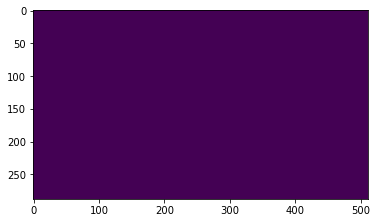

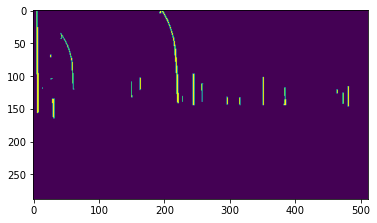

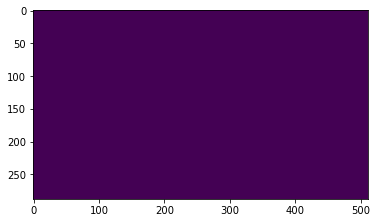

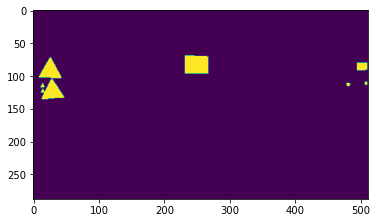

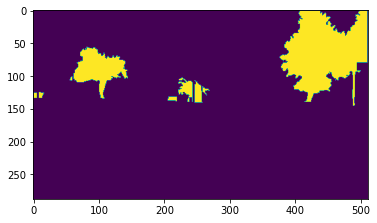

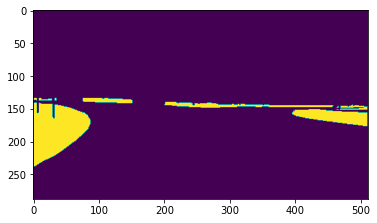

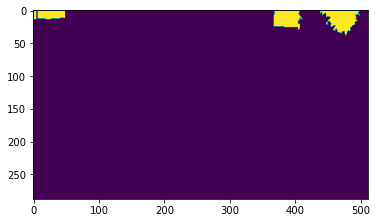

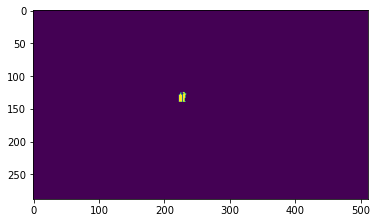

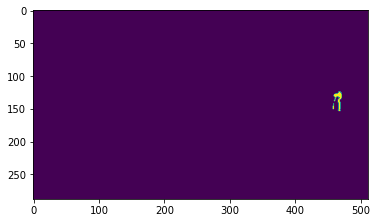

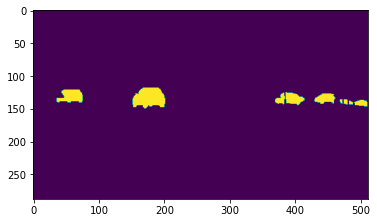

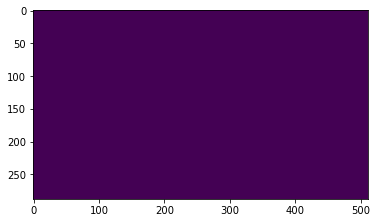

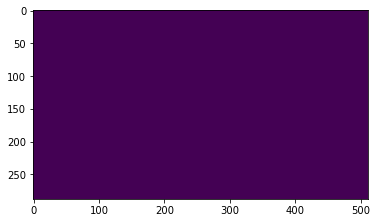

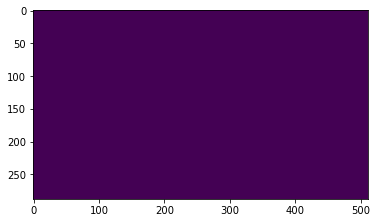

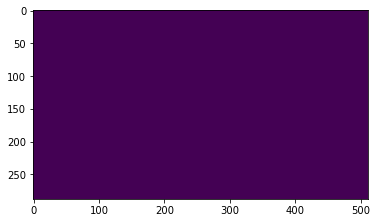

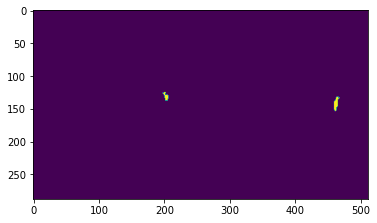

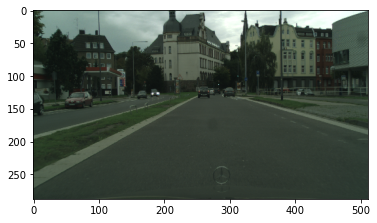

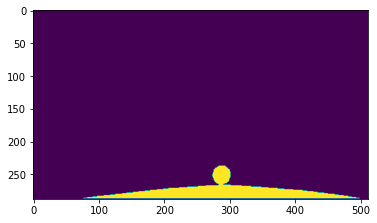

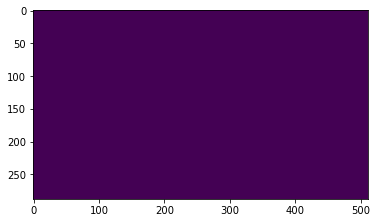

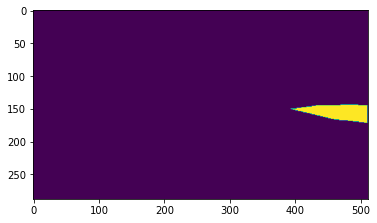

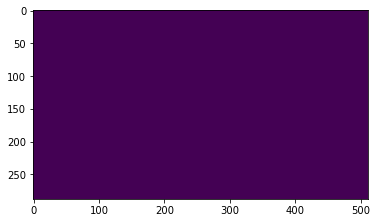

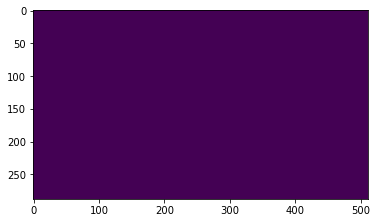

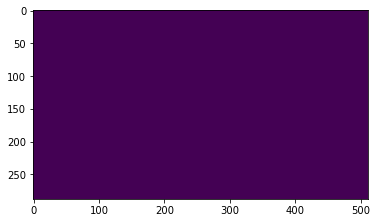

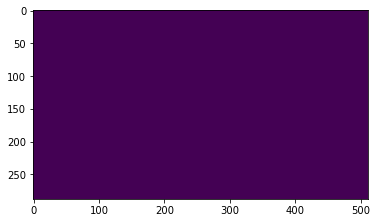

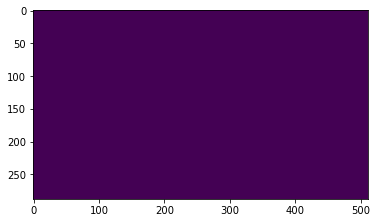

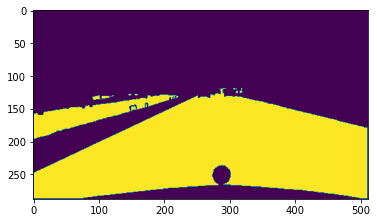

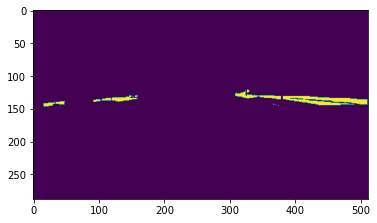

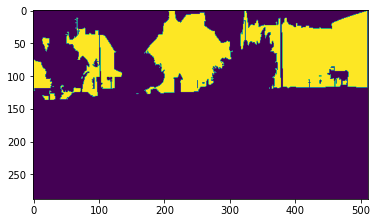

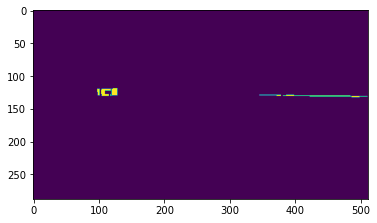

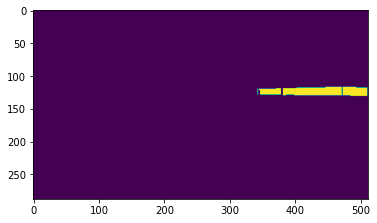

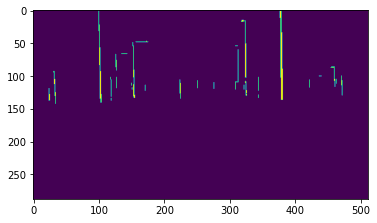

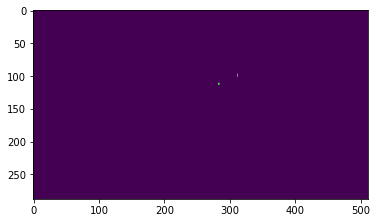

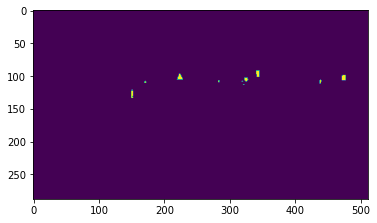

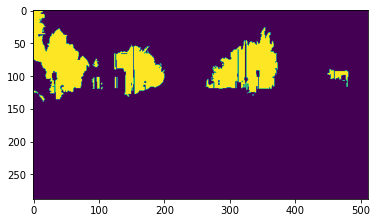

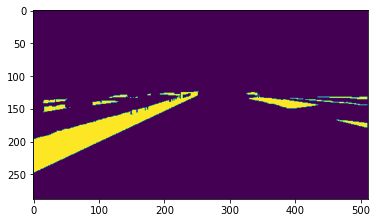

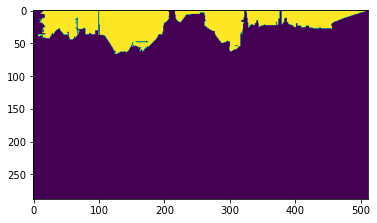

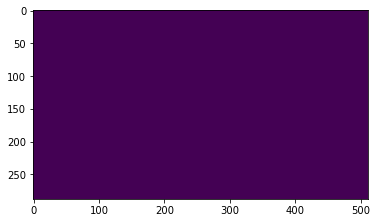

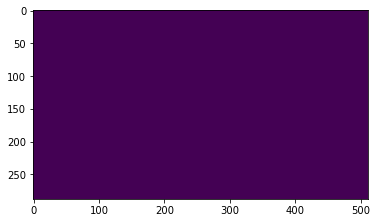

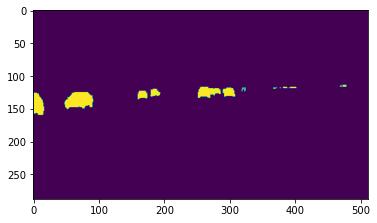

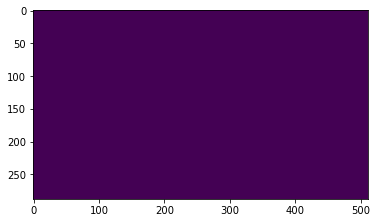

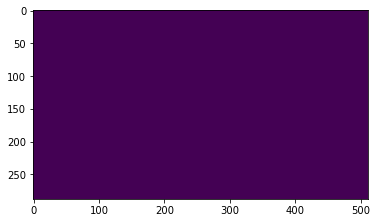

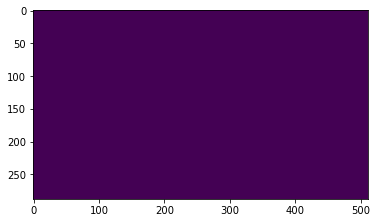

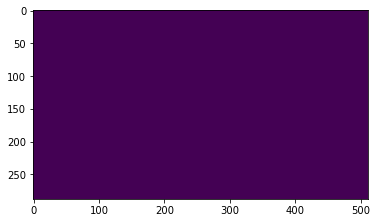

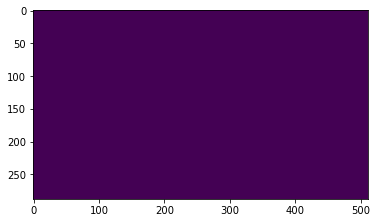

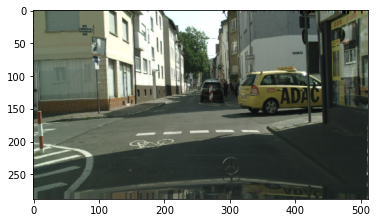

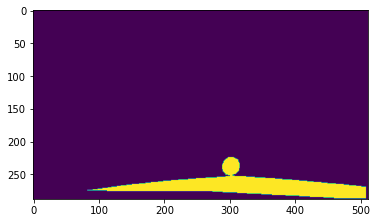

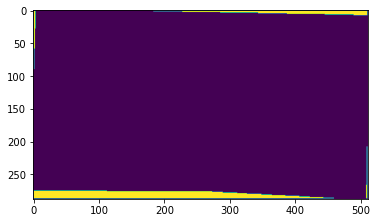

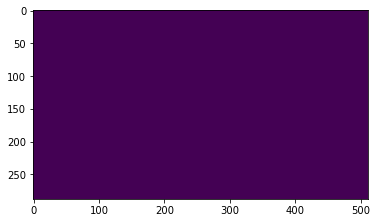

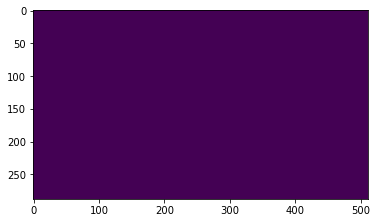

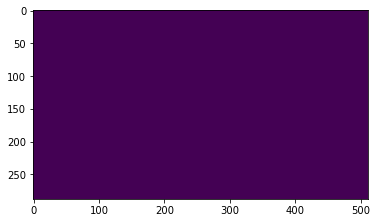

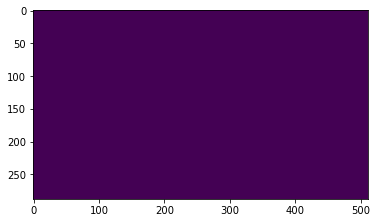

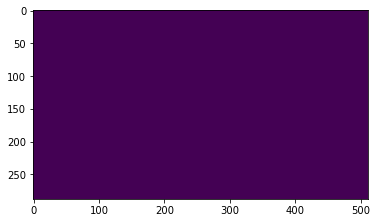

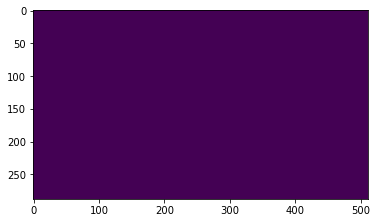

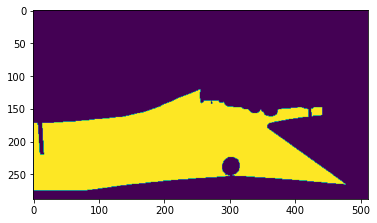

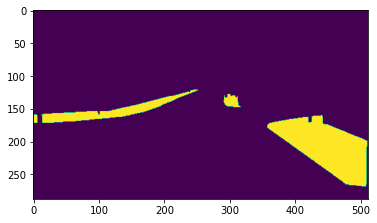

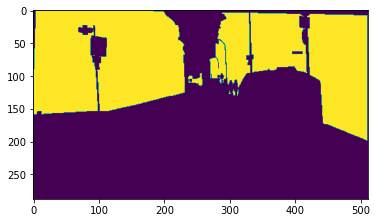

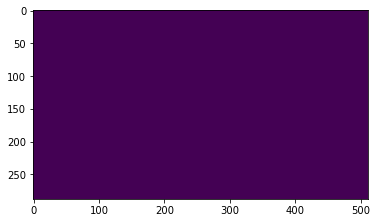

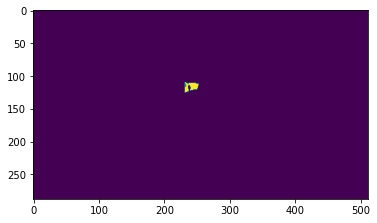

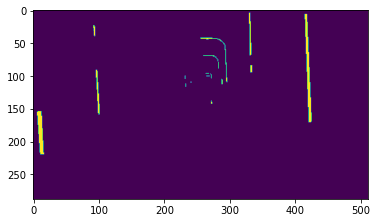

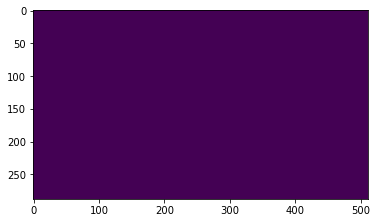

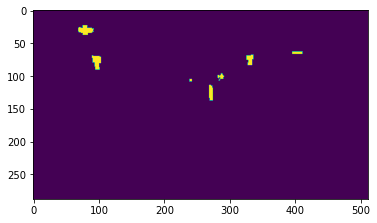

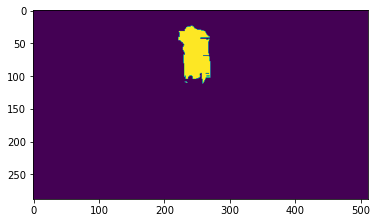

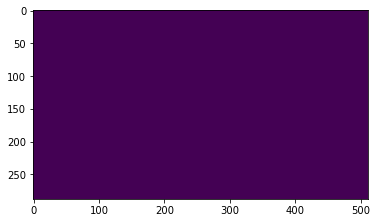

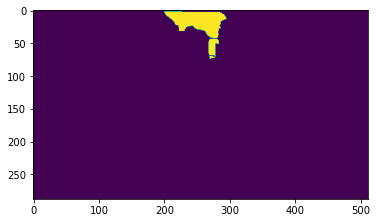

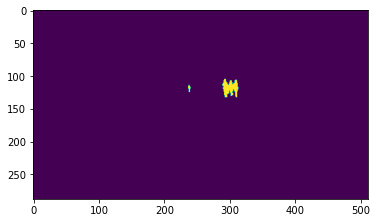

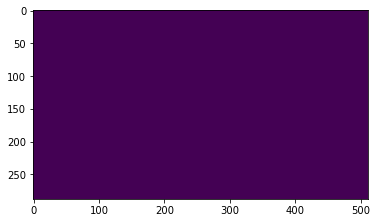

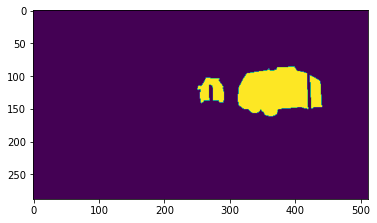

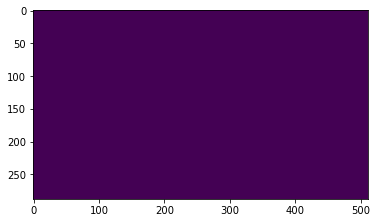

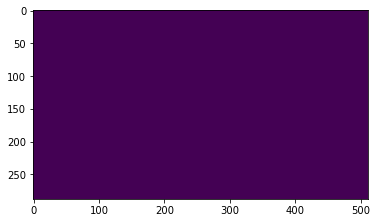

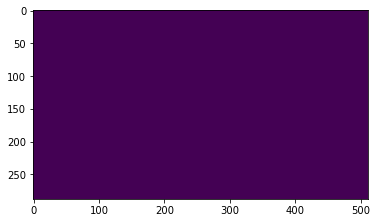

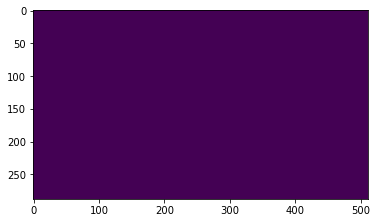

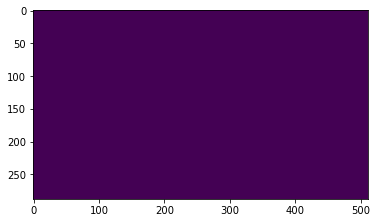

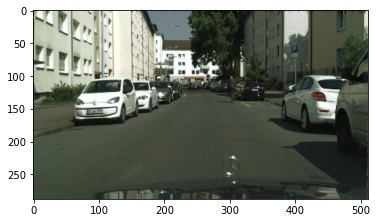

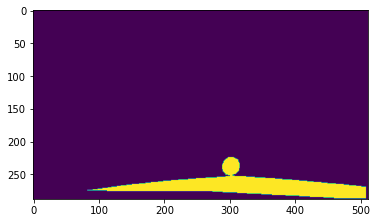

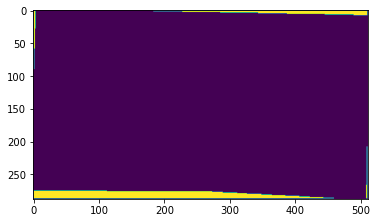

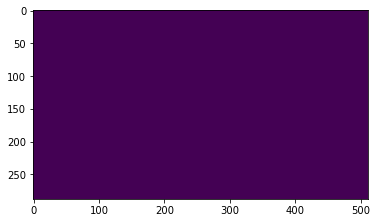

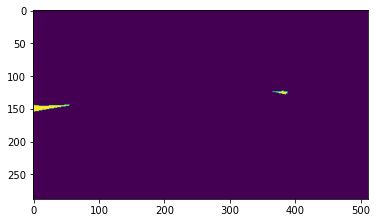

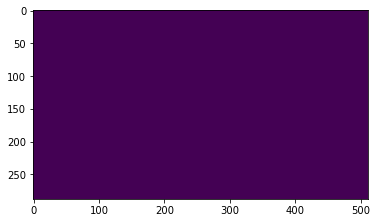

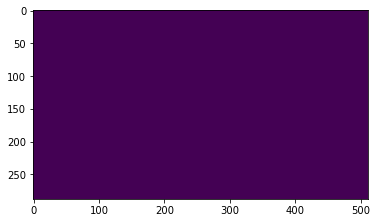

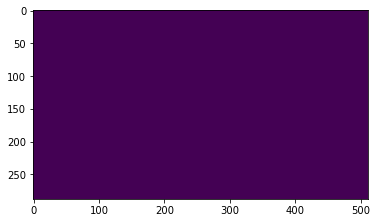

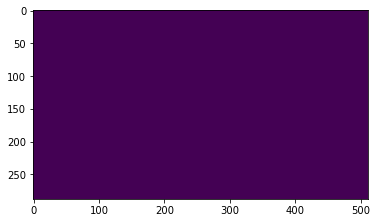

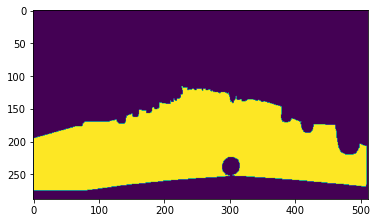

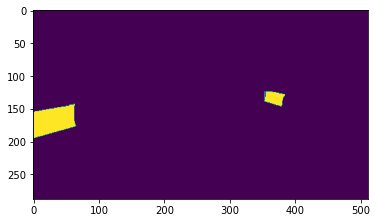

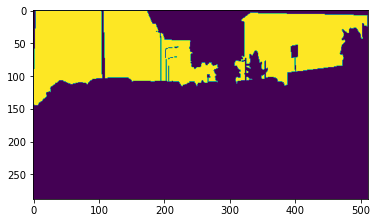

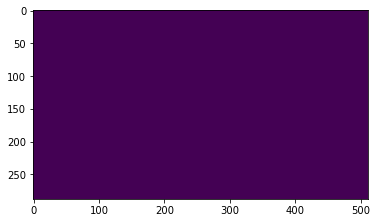

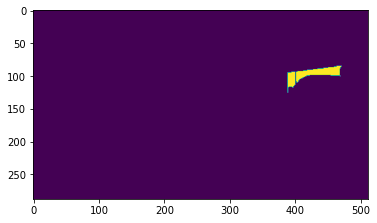

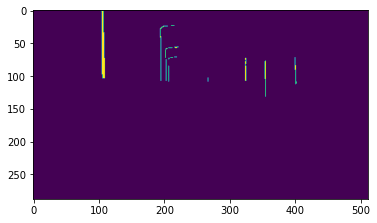

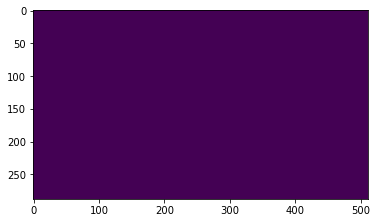

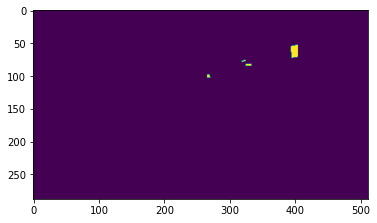

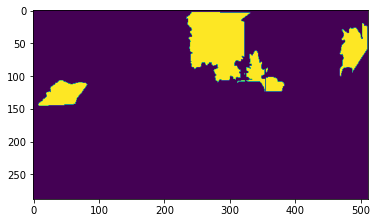

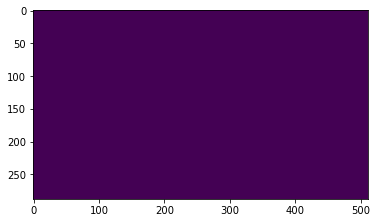

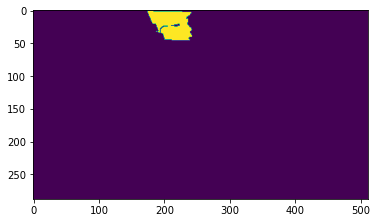

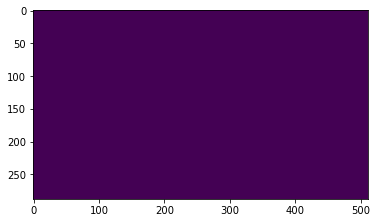

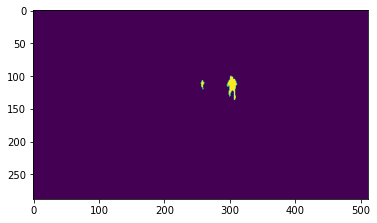

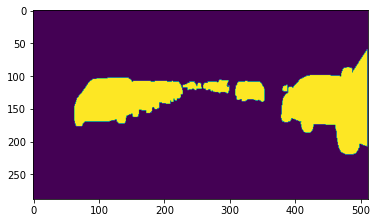

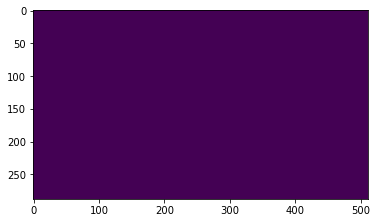

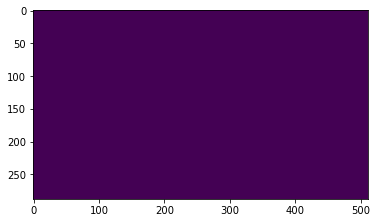

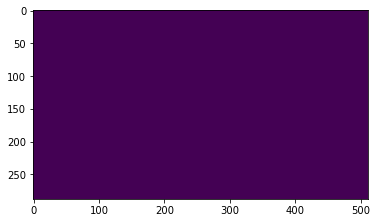

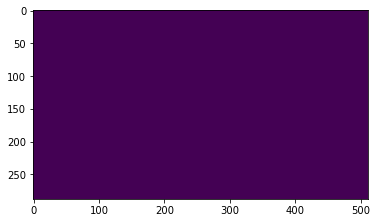

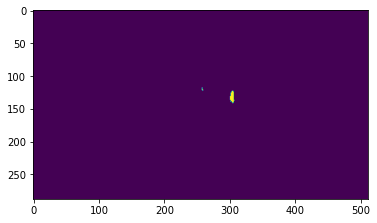

In [17]:
for image, mask in train_ds.take(2):
    plt.imshow(image)
    plt.show()
    for i in range(mask.shape[2]):
        
        plt.imshow(mask[:,:,i])
        plt.show()

    
for image, mask in val_ds.take(2):
    plt.imshow(image)
    plt.show()
    for i in range(mask.shape[2]):
        
        plt.imshow(mask[:,:,i])
        plt.show()

In [18]:
def configure_for_performance(ds):
  ds = ds.cache(filename = "cache")
  ds = ds.shuffle(buffer_size=100, reshuffle_each_iteration = True)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  
  return ds

train_ds_1 = configure_for_performance(train_ds)
val_ds_1 = configure_for_performance(val_ds)

STEPS_PER_EPOCH = len(train_ds_1)
STEPS_PER_EPOCH


744

In [19]:

model = get_model(NUM_CLASSES)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 288, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 288, 512, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
normalization (Normalization)   (None, 288, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 289, 513, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

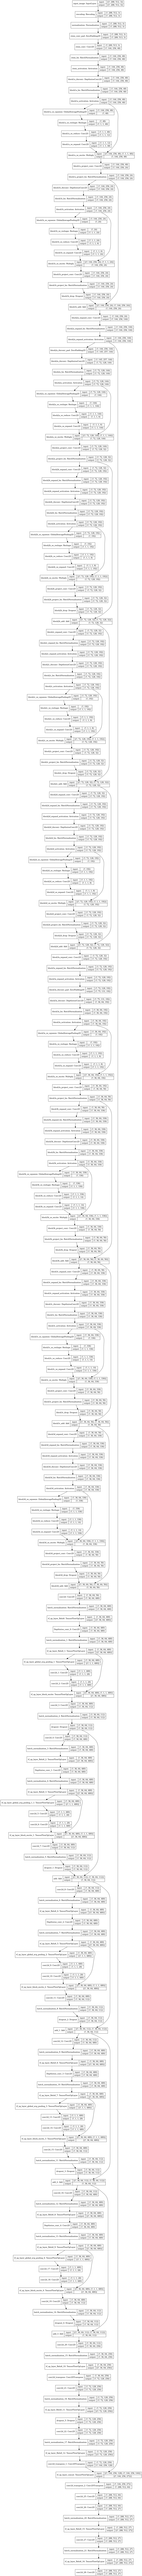

In [20]:
tf.keras.utils.plot_model(model, to_file = "EffModel.png", show_shapes = True)

In [21]:

# def F_beta_score(class_labels, pred_labels):
   

#     beta =1.0 #[1.0 , 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,  1.0, 1.0, 1.0, 1.0, 1.4, 1.4, 1.4,  1.3, 1.5, 1.5, 1.0]
#     class_labels = tf.cast(tf.reshape(class_labels, (-1, NUM_CLASSES)), dtype = tf.float32)
#     pred_labels  = tf.reshape(pred_labels, (-1, NUM_CLASSES))
#     pred_labels = tf.nn.softmax(pred_labels, axis = -1)
#     numerator = (1 + tf.square(beta)) * (tf.reduce_sum(class_labels * pred_labels, axis  = 0) )
#     denominator = (tf.square(beta)) * tf.reduce_sum(class_labels ,axis = 0) + tf.reduce_sum(pred_labels ,axis = 0)
 
    
#     return tf.reduce_sum( (numerator + tf.keras.backend.epsilon())/(denominator + tf.keras.backend.epsilon()))

def iou(class_labels, pred_labels):
    pred_labels = tf.nn.softmax(pred_labels, axis = -1)
    class_labels = tf.cast(tf.reshape(class_labels, (-1, NUM_CLASSES)), tf.float32)
    pred_labels  = tf.reshape(pred_labels, (-1, NUM_CLASSES))
    intersection = tf.reduce_sum(class_labels * pred_labels, axis = 0)
    union = (tf.reduce_sum(tf.square(class_labels), axis = 0) + tf.reduce_sum(tf.square(pred_labels), axis = 0) ) - intersection
     
    return (tf.reduce_mean(intersection)) / (tf.reduce_mean(union)  + tf.keras.backend.epsilon()) 
    

def accuracy(y_true, y_pred):
   
    y_true = y_true[:,:,5:]
    y_pred = y_pred[:,:,5:]
    y_true = tf.argmax(y_true, axis = -1)
    y_pred = tf.argmax(y_pred, axis = -1)
    
    return tf.reduce_mean(tf.cast(y_true == y_pred, dtype = tf.float32))

# def ce_loss(class_labels, pred_labels):
#     weights = [0.7, 0.7, 0.7, 0.7, 1.0, 0.7, 0.7, 0.8, 0.8, 0.7, 0.8, 0.8, 0.8,  0.8, 1.2, 1.2, 1.2, 1.0, 1.0, 0.8, 1.4, 1.4, 1.1, 1.0, 1.0, 1.0, 1.3, 1.3]
#     class_labels = tf.cast(tf.reshape(class_labels, (-1, NUM_CLASSES)), dtype = tf.float32) * weights
#     pred_labels  = tf.reshape(pred_labels, (-1, NUM_CLASSES))
#     return tf.nn.softmax_cross_entropy_with_logits(class_labels, pred_labels) 

def cce_loss(y_true, y_pred):
#     y_true = tf.cast(tf.reshape(y_true, (-1, NUM_CLASSES)), dtype = tf.float32)
#     y_pred = tf.reshape(y_pred, (-1, NUM_CLASSES))
    y_true = tf.cast(y_true, dtype = tf.float32)
    
    return tf.reduce_mean(-tf.reduce_sum(((1.0-tf.nn.softmax(y_pred, axis = -1))** 2) * y_true * tf.nn.log_softmax(y_pred, axis = -1), axis = -1))
    
    
    
    #weights =  tf.math.pow(y_true - tf.nn.softmax(y_pred, axis = -1), 2)
    #y_true = y_true * weights
    #return tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred) 
      
def modified_loss(y_true, y_pred):
    return cce_loss(y_true, y_pred)

In [22]:
tf.keras.backend.clear_session()


           
max_lr = 0.00008
base_lr = 1e-7


step_size = 6



def get_callbacks():

    best_path = f"{os.getcwd()}" + "/best_checkpoint_1/checkpoint"
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = best_path,
                                                         monitor = "val_loss",
                                                         verbose = 0,
                                                         mode = "min",
                                                         save_best_only = True,
                                                         save_weights_only =True,
                                                         save_freq = "epoch")
    
    
    latest_path = f"{os.getcwd()}" + "/latest_checkpoint_1/checkpoint"
    latest_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = latest_path,
                                                         monitor = "val_loss",
                                                         verbose = 0,
                                                         mode = "min",
                                                         save_best_only = False,
                                                         save_weights_only =True,
                                                         save_freq = "epoch")
    
    
    reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = "loss",
                                                                factor = 0.1,
                                                                patience =70,
                                                                verbose= 0,
                                                                mode = "min",
                                                                min_delta=0.0001)
    
    
            
        
    
    
    clr_schedule = ExponentialCyclicalLearningRate(initial_learning_rate = base_lr,
                                                            maximal_learning_rate = max_lr,
                                                            step_size =  step_size,
                                                            scale_mode ='iterations',
                                                            gamma = 0.94)
    def schedule(epoch, lr):
        lr *= ((1 - (epoch/NUM_EPOCHS))) ** 0.999
        
        return lr

                                                            
    
    cyclical_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(clr_schedule, verbose=0)
    
    
    
    
    
    
    
    
    
    return [best_checkpoint, reduce_lr_on_plateau, cyclical_lr_scheduler, latest_checkpoint, WandbCallback()]



In [23]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.00009), loss = modified_loss, metrics = [iou, accuracy])

callbacks = get_callbacks()

In [24]:
model.load_weights(f"{os.getcwd()}" + "/best_checkpoint_1/checkpoint")
model.trainable = True

In [28]:
model.fit(train_ds_1,
          epochs=NUM_EPOCHS,
          steps_per_epoch = STEPS_PER_EPOCH,
          validation_data = val_ds_1,
          validation_steps = 1,
          callbacks = callbacks,
          verbose = 1)

Epoch 1/300
744/744 [==============================] - 427s 574ms/step - loss: 0.0559 - iou: 0.8907 - accuracy: 0.9252 - val_loss: 0.0457 - val_iou: 0.8950 - val_accuracy: 0.9278
Epoch 2/300
744/744 [==============================] - 429s 576ms/step - loss: 0.0550 - iou: 0.8925 - accuracy: 0.9259 - val_loss: 0.0426 - val_iou: 0.9130 - val_accuracy: 0.9446
Epoch 3/300
744/744 [==============================] - 422s 567ms/step - loss: 0.0540 - iou: 0.8936 - accuracy: 0.9265 - val_loss: 0.0413 - val_iou: 0.8985 - val_accuracy: 0.9273
Epoch 4/300
744/744 [==============================] - 422s 567ms/step - loss: 0.0543 - iou: 0.8934 - accuracy: 0.9263 - val_loss: 0.0533 - val_iou: 0.8775 - val_accuracy: 0.9107
Epoch 5/300
744/744 [==============================] - 422s 567ms/step - loss: 0.0539 - iou: 0.8938 - accuracy: 0.9264 - val_loss: 0.0415 - val_iou: 0.9136 - val_accuracy: 0.9455
Epoch 6/300
744/744 [==============================] - 422s 568ms/step - loss: 0.0542 - iou: 0.8934 - acc

KeyboardInterrupt: 

In [25]:
image, mask = next(iter(train_ds_1))

In [26]:
image.shape, mask.shape

(TensorShape([4, 288, 512, 3]), TensorShape([4, 288, 512, 27]))

In [27]:
image.shape

TensorShape([4, 288, 512, 3])

In [28]:
model.predict(image)

array([[[[ -9.529707 ,  -3.6024425,  -3.707587 , ...,  -3.9189568,
           -4.0887437,  -4.6144753],
         [-16.798683 ,  -2.1820104,  -5.142483 , ...,  -6.3680444,
           -6.0439835,  -6.116658 ],
         [-22.56275  ,  -4.0049677,  -5.1296268, ...,  -6.121467 ,
           -5.4818034,  -5.5752745],
         ...,
         [-29.928211 ,  -2.8358912,  -6.0794773, ...,  -8.355572 ,
           -7.8407354,  -8.510727 ],
         [-26.703457 ,  -3.2768009,  -6.0458794, ...,  -7.0352583,
           -7.466954 ,  -8.206412 ],
         [-17.057266 ,  -2.700606 ,  -3.944054 , ...,  -4.9876585,
           -5.045414 ,  -5.7229786]],

        [[-13.1649475,  -3.9622757,  -5.3146453, ...,  -5.685503 ,
           -6.424709 ,  -6.3973207],
         [-24.190865 ,  -4.3701386,  -7.152696 , ...,  -8.435104 ,
           -8.491528 ,  -8.19388  ],
         [-32.448166 ,  -6.7441206,  -7.6871905, ...,  -8.770247 ,
           -9.068782 ,  -8.131236 ],
         ...,
         [-42.609913 ,  -8.149753 

In [29]:
import time
tic = time.time()
predictions = tf.argmax(model.predict(image), axis = -1)
toc = time.time()
print("The Inference Time of the model is",toc-tic)

The Inference Time of the model is 0.4951343536376953


In [30]:
a = tf.Variable([4,5,-9.0])
tf.argmax(a, axis = -1)

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [31]:
predictions.shape

TensorShape([4, 288, 512])

In [32]:
ground_truth = tf.argmax(mask, axis = -1)

In [33]:
ground_truth.shape

TensorShape([4, 288, 512])

In [34]:
print(np.unique(predictions[2]))

print(np.unique(ground_truth[2]))


[ 0  1  8  9 10 11 12 13 15 16 18 19 21]
[ 0  2  8  9 10 11 12 13 14 15 16 18 19 20 21 25]


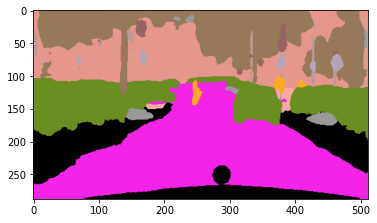

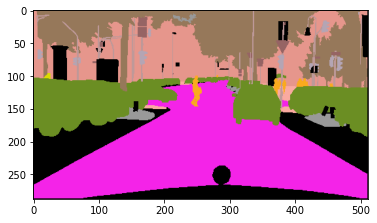

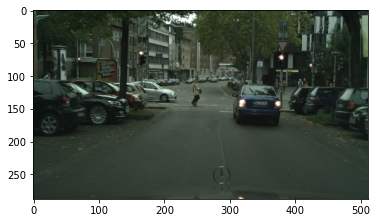

In [35]:

def fill_color(pixel):
    

    
    for i in range(35):
        
        if pixel == i:
            
            return np.array(mask_pallete[i])
        
    else:
        return np.array([255,255,255])
    
color_label = np.apply_along_axis(fill_color, axis = 2, arr = np.expand_dims(predictions[0], axis = 2))


plt.imshow(color_label)
wandb.log({"predictions": wandb.Image(plt)})
plt.show()
color_truth = np.apply_along_axis(fill_color, axis = 2, arr = np.expand_dims(ground_truth[0], axis = 2))
plt.imshow(color_truth)

wandb.log({"ground_truth": wandb.Image(plt)})
plt.show()

plt.imshow(image[0])
wandb.log({"Original Image": wandb.Image(plt)})
plt.show()

In [45]:
test_ds = tf.data.Dataset.list_files(str(images_dir)+ "test/*/*", shuffle = False)

In [46]:
def process_test(image_dir):
    img = tf.io.read_file(image_dir)
    
    img = decode_img(img)
    
    return img
test_ds = test_ds.map(process_test, AUTOTUNE)

In [47]:
def configure_test_performance(ds):
  ds = ds.shuffle(buffer_size=100, reshuffle_each_iteration = True)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  
  return ds
test_ds = configure_test_performance(test_ds)

In [69]:
image = next(iter(test_ds))

In [70]:
import time
tic = time.time()
predictions = tf.argmax(tf.nn.softmax(model.predict(image), axis = -1), axis = -1)
toc = time.time()
print("The Inference Time of the model is",toc-tic)

The Inference Time of the model is 0.47297215461730957


In [71]:
predictions.shape

TensorShape([4, 288, 512])

In [72]:
print(np.unique(predictions))

[ 0  1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26]


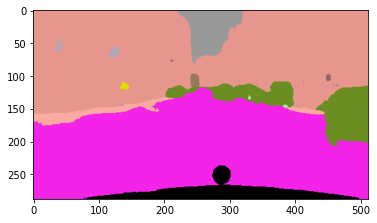

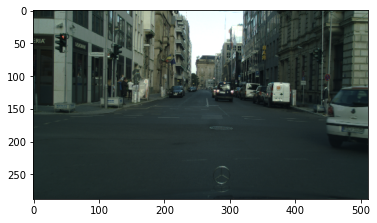

In [73]:
    
color_label = np.apply_along_axis(fill_color, axis = 2, arr = np.expand_dims(predictions[0], axis = 2))

plt.imshow(color_label)
wandb.log({"test_predictions": wandb.Image(plt)})
plt.show()


plt.imshow(image[0])

wandb.log({"test_Original Image": wandb.Image(plt)})
plt.show()

In [74]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 288, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 288, 512, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
normalization (Normalization)   (None, 288, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 289, 513, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

__________________________________________________________________________________________________
block2b_se_expand (Conv2D)      (None, 1, 1, 192)    1728        block2b_se_reduce[0][0]          
__________________________________________________________________________________________________
block2b_se_excite (Multiply)    (None, 72, 128, 192) 0           block2b_activation[0][0]         
                                                                 block2b_se_expand[0][0]          
__________________________________________________________________________________________________
block2b_project_conv (Conv2D)   (None, 72, 128, 32)  6144        block2b_se_excite[0][0]          
__________________________________________________________________________________________________
block2b_project_bn (BatchNormal (None, 72, 128, 32)  128         block2b_project_conv[0][0]       
__________________________________________________________________________________________________
block2b_dr

__________________________________________________________________________________________________
block3b_activation (Activation) (None, 36, 64, 336)  0           block3b_bn[0][0]                 
__________________________________________________________________________________________________
block3b_se_squeeze (GlobalAvera (None, 336)          0           block3b_activation[0][0]         
__________________________________________________________________________________________________
block3b_se_reshape (Reshape)    (None, 1, 1, 336)    0           block3b_se_squeeze[0][0]         
__________________________________________________________________________________________________
block3b_se_reduce (Conv2D)      (None, 1, 1, 14)     4718        block3b_se_reshape[0][0]         
__________________________________________________________________________________________________
block3b_se_expand (Conv2D)      (None, 1, 1, 336)    5040        block3b_se_reduce[0][0]          
__________

tf_op_layer_Relu6_2 (TensorFlow [(None, 36, 64, 480) 0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
Depthwise_conv_1 (Conv2D)       (None, 36, 64, 480)  2074080     tf_op_layer_Relu6_2[0][0]        
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 36, 64, 480)  1920        Depthwise_conv_1[0][0]           
__________________________________________________________________________________________________
tf_op_layer_Relu6_3 (TensorFlow [(None, 36, 64, 480) 0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
tf_op_layer_global_avg_pooling_ [(None, 1, 1, 480)]  0           tf_op_layer_Relu6_3[0][0]        
__________________________________________________________________________________________________
conv2d_5 (

__________________________________________________________________________________________________
add_3 (Add)                     (None, 36, 64, 112)  0           add_2[0][0]                      
                                                                 dropout_4[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 36, 64, 256)  258304      add_3[0][0]                      
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 36, 64, 256)  1024        conv2d_20[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Relu6_10 (TensorFlo [(None, 36, 64, 256) 0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
conv2d_tra

In [189]:
activate = Model(model.inputs, model.get_layer("block2a_expand_activation").output)

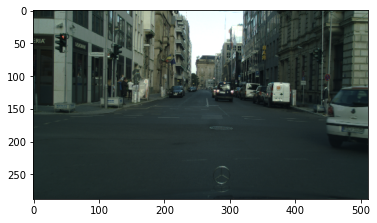

In [190]:
plt.imshow(image[0])

In [191]:
activations = activate(image, training= False)

In [192]:
activations = activations[0]

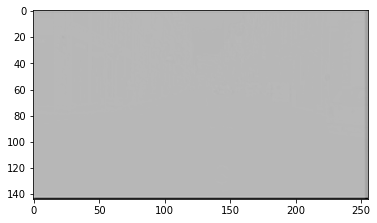

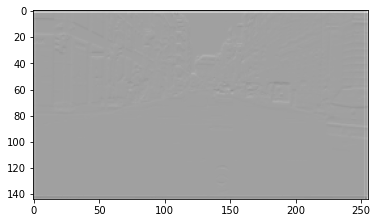

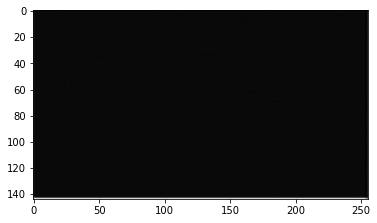

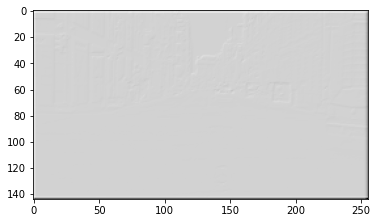

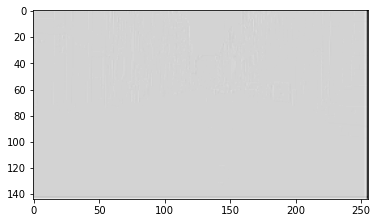

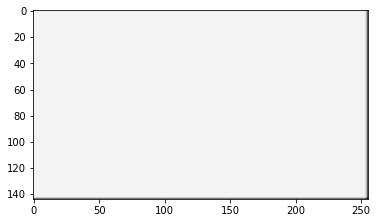

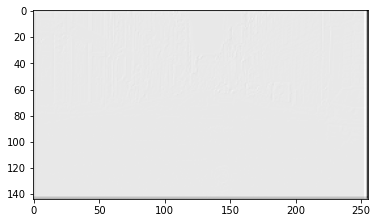

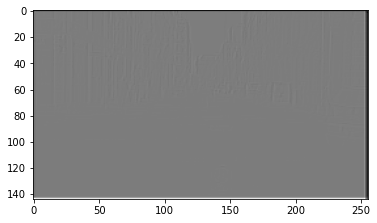

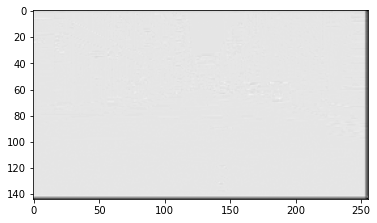

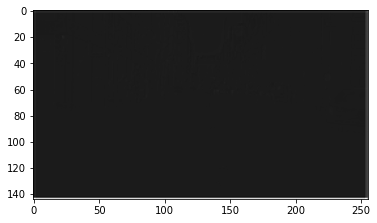

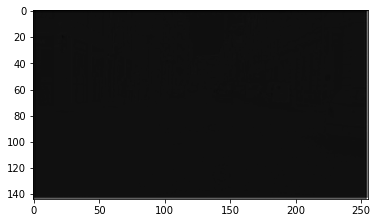

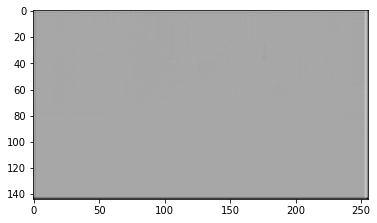

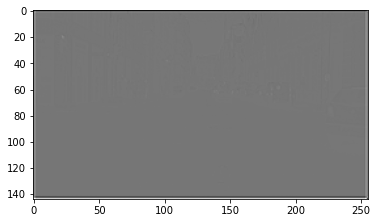

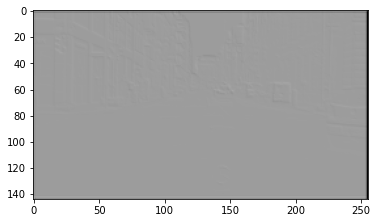

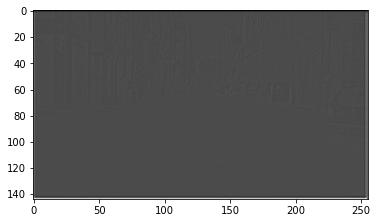

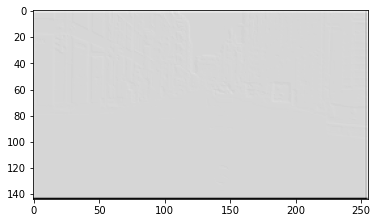

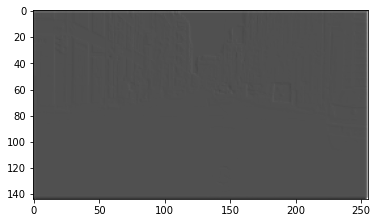

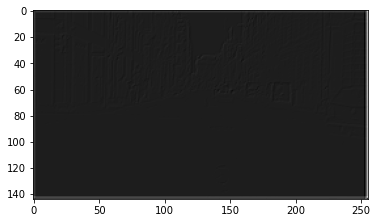

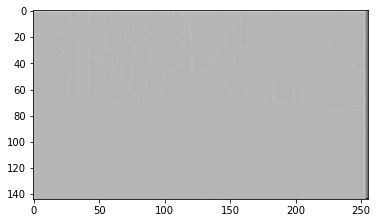

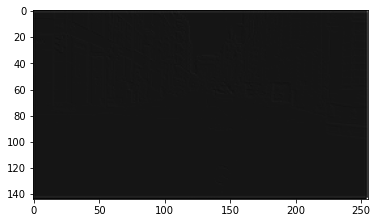

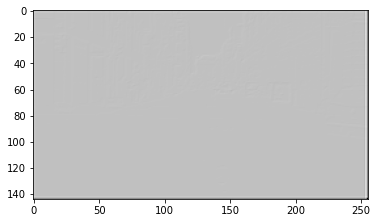

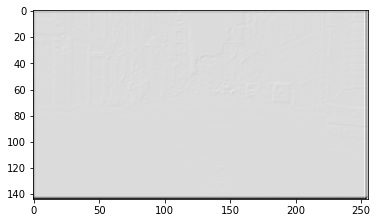

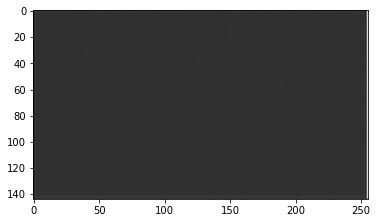

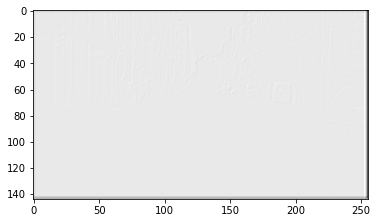

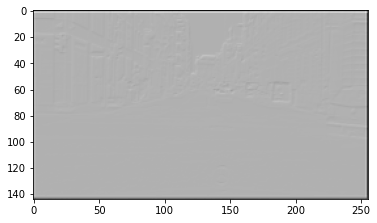

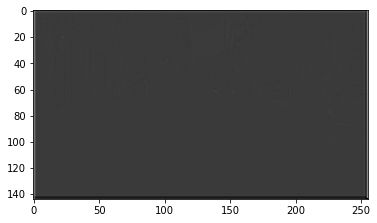

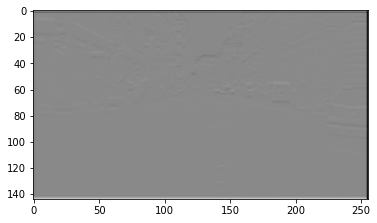

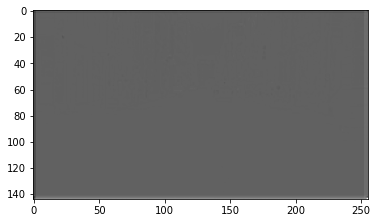

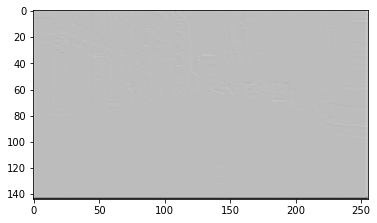

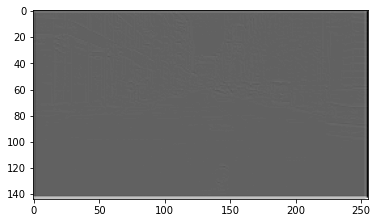

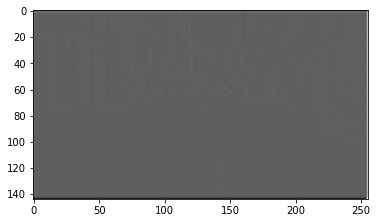

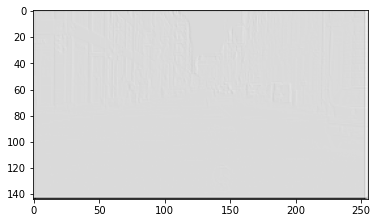

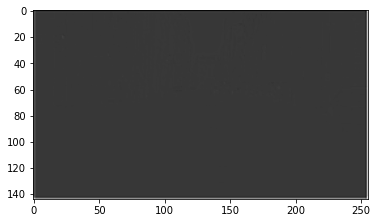

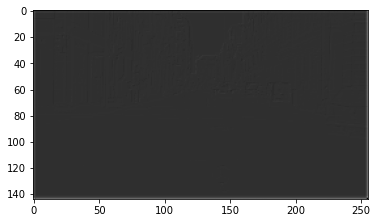

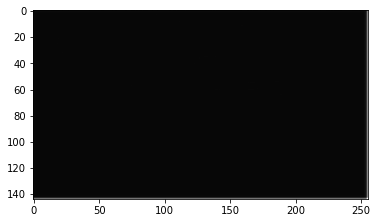

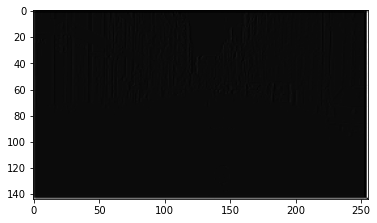

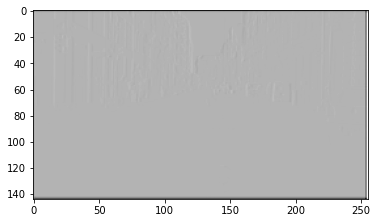

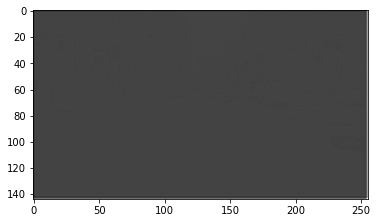

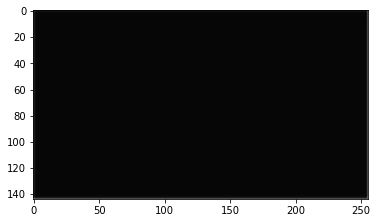

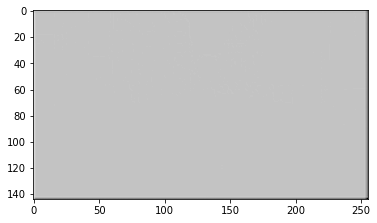

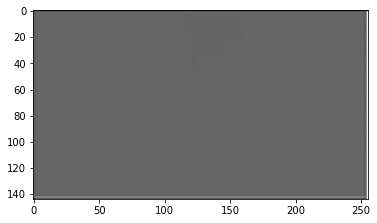

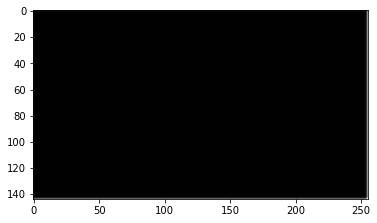

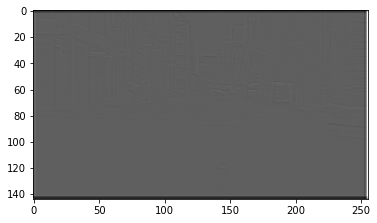

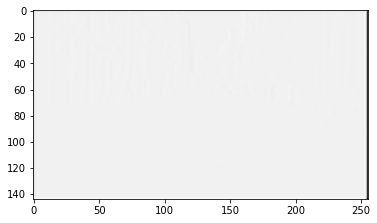

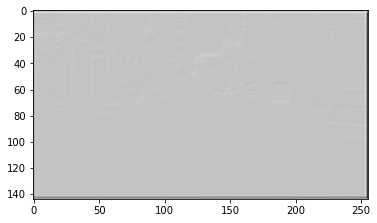

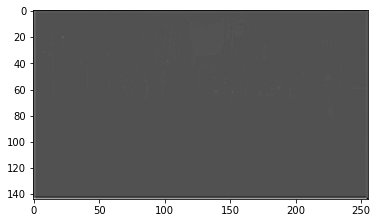

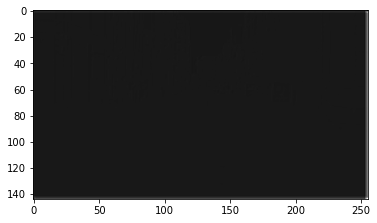

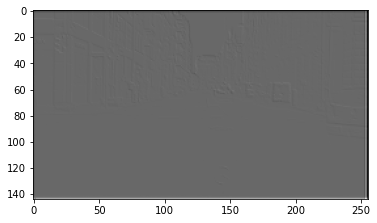

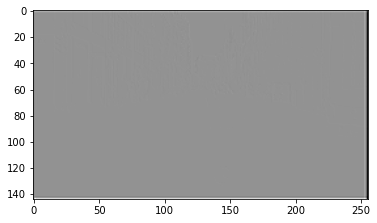

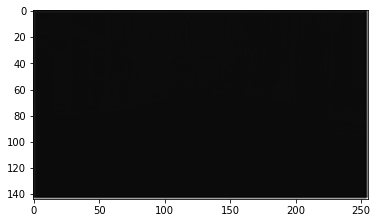

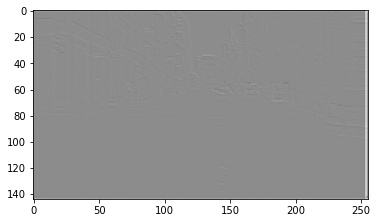

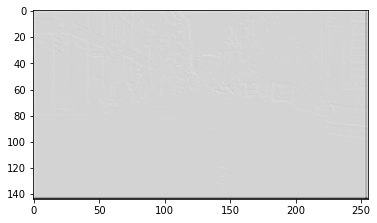

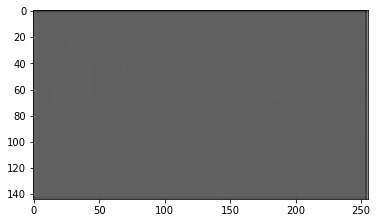

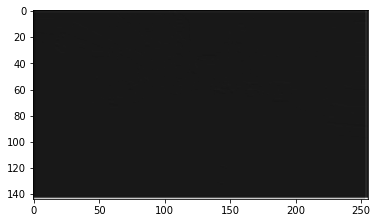

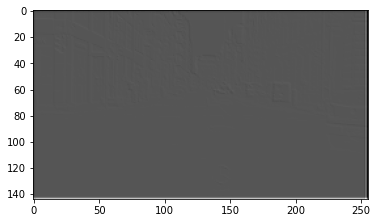

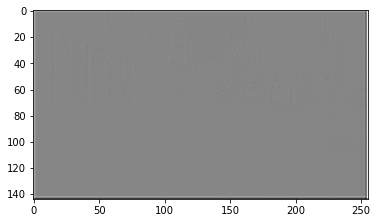

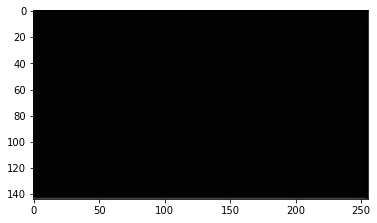

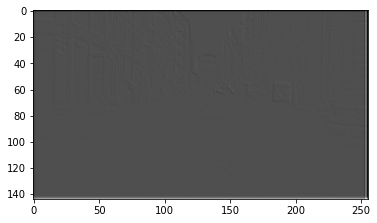

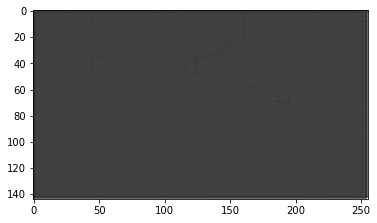

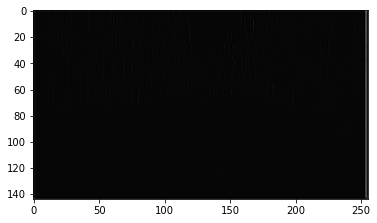

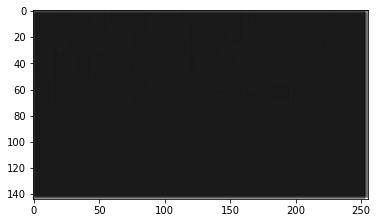

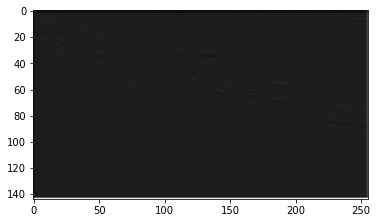

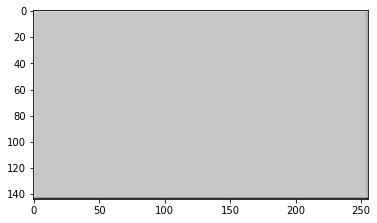

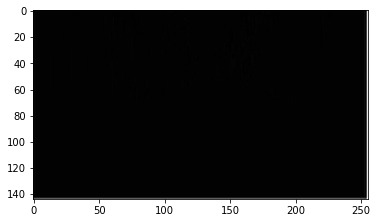

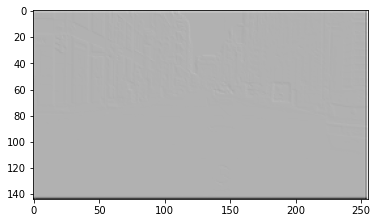

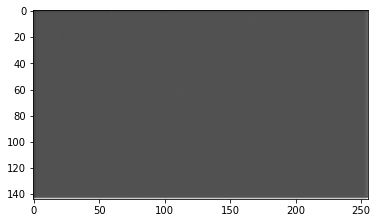

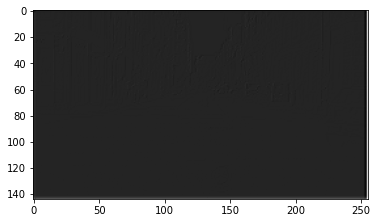

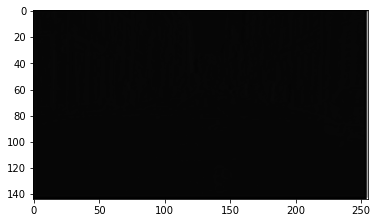

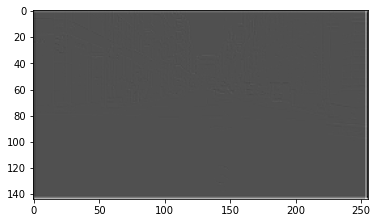

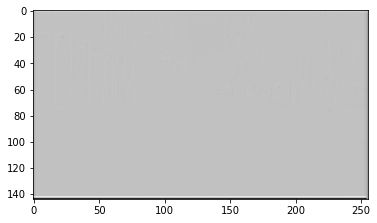

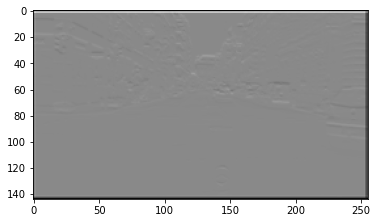

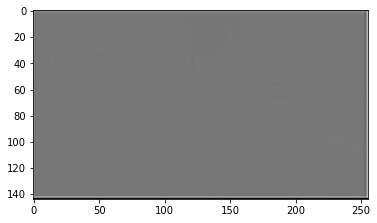

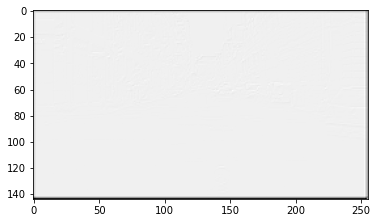

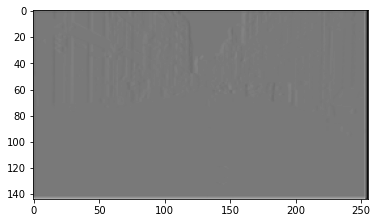

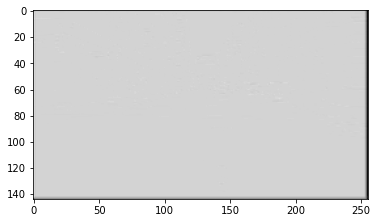

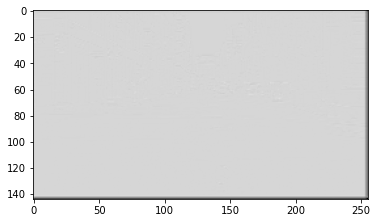

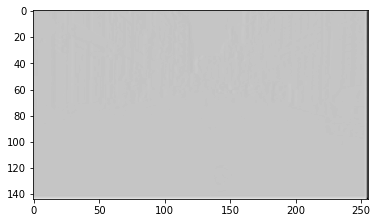

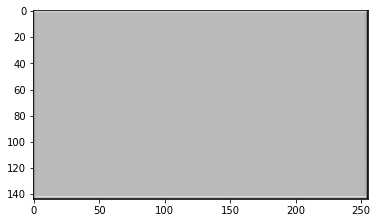

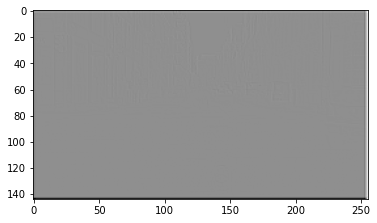

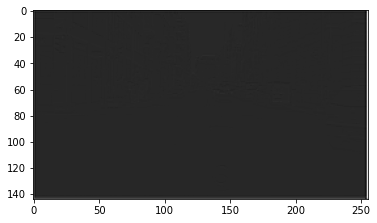

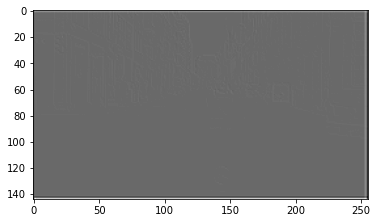

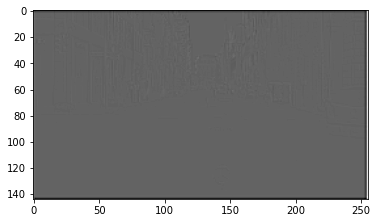

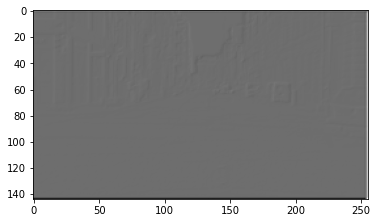

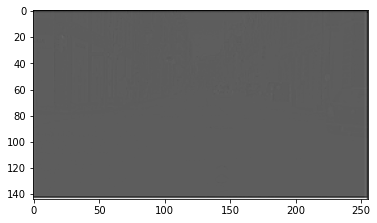

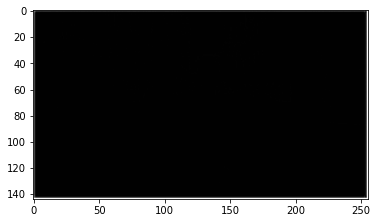

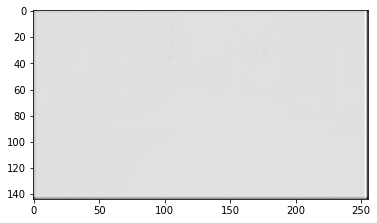

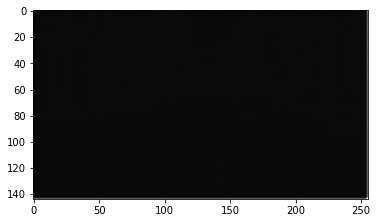

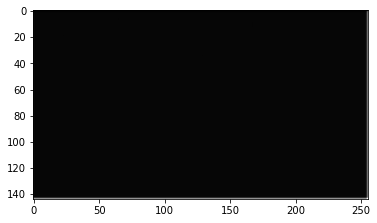

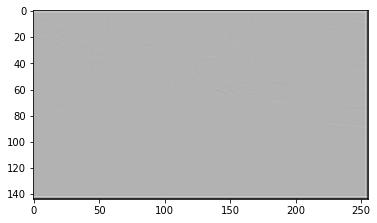

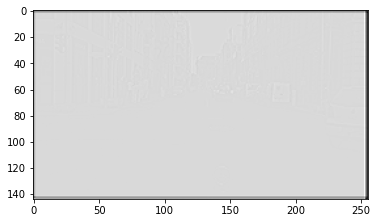

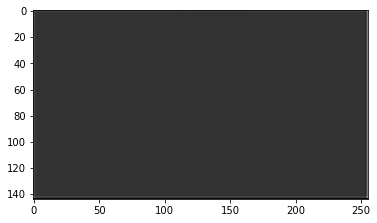

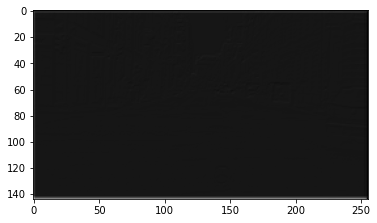

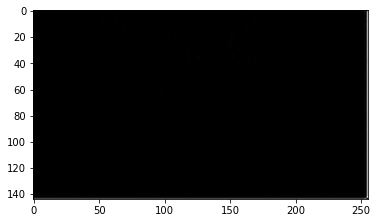

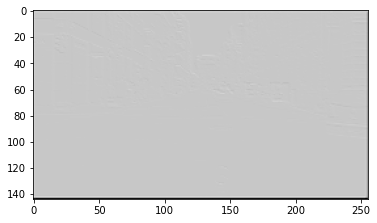

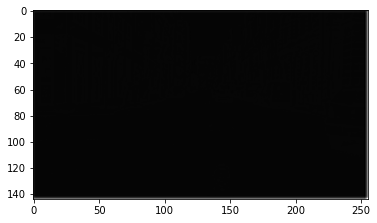

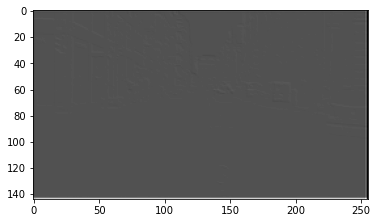

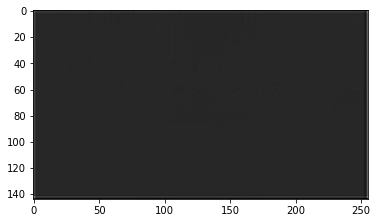

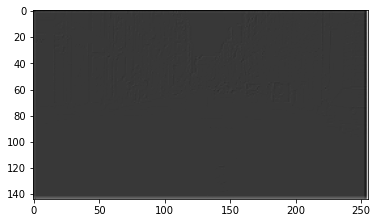

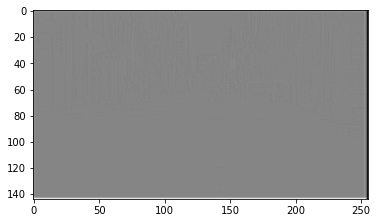

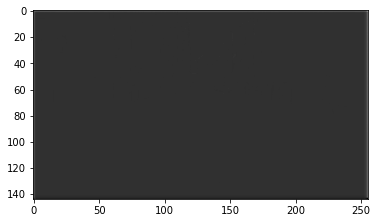

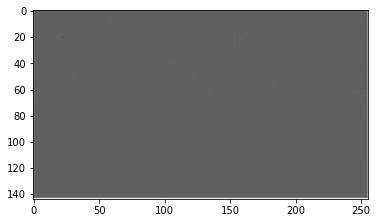

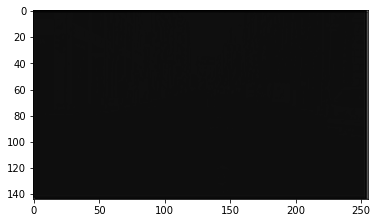

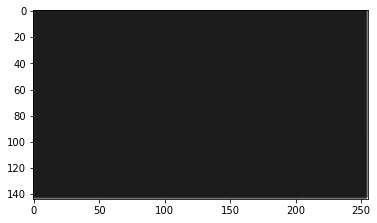

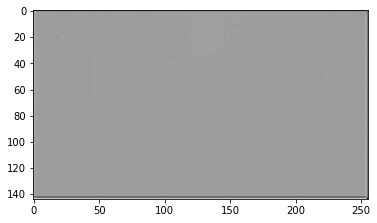

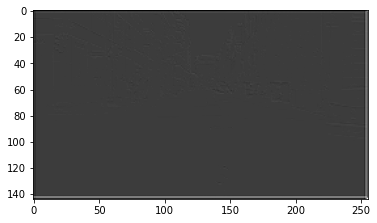

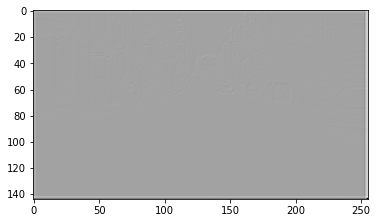

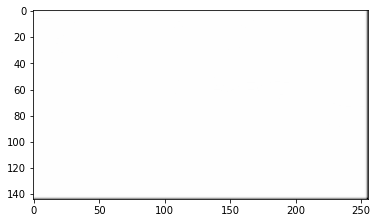

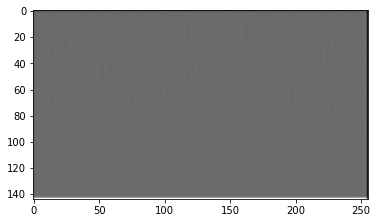

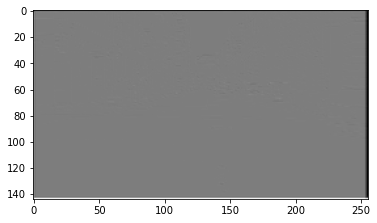

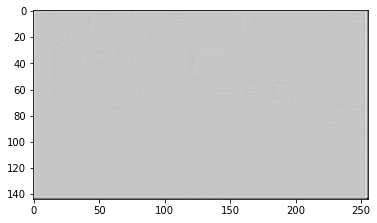

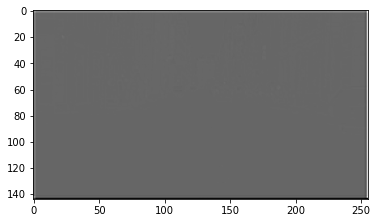

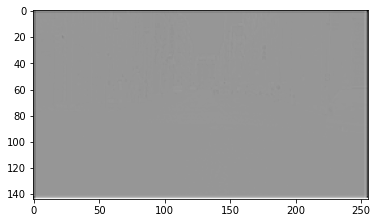

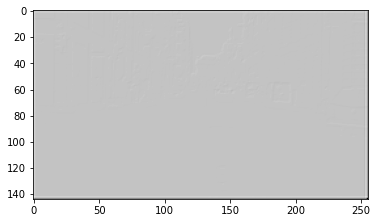

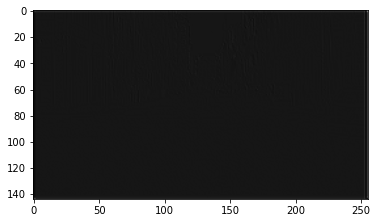

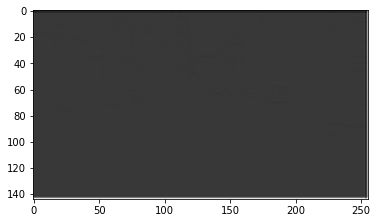

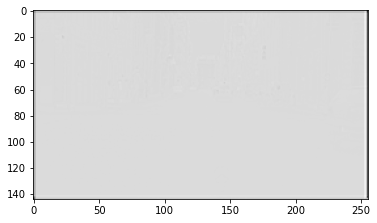

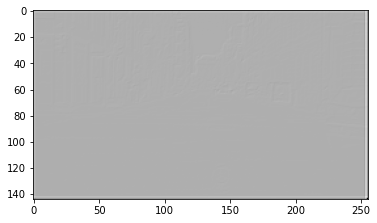

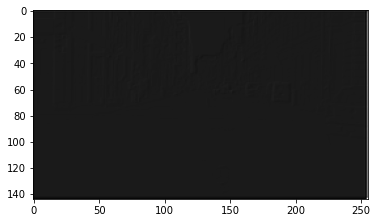

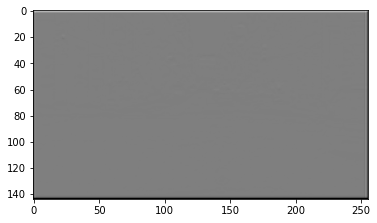

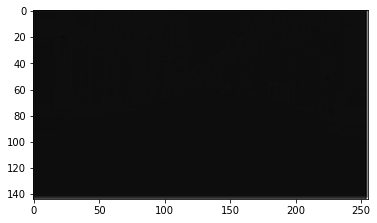

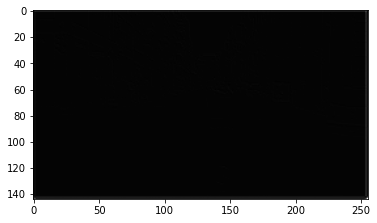

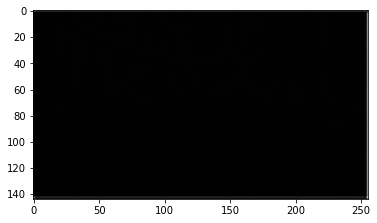

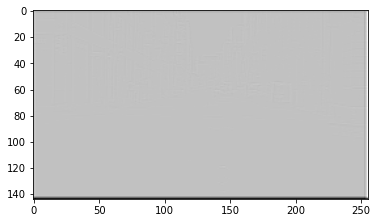

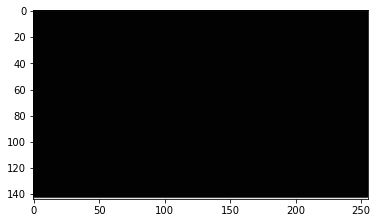

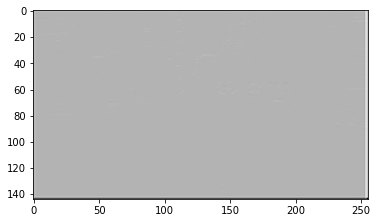

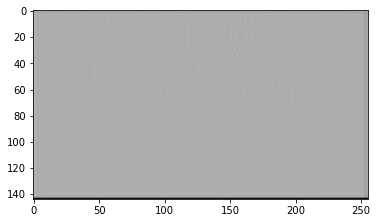

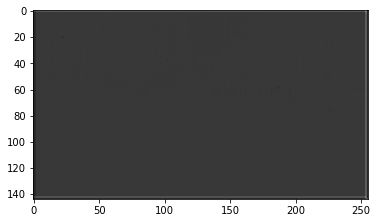

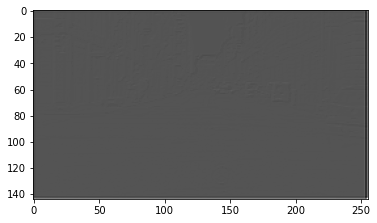

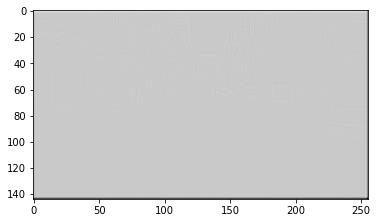

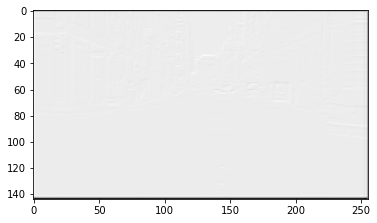

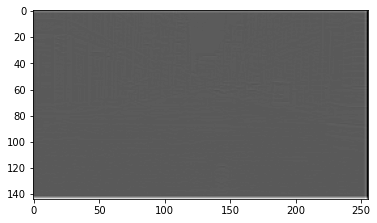

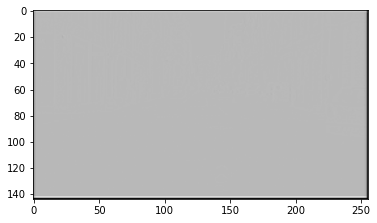

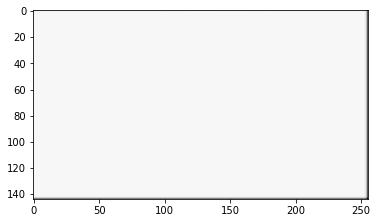

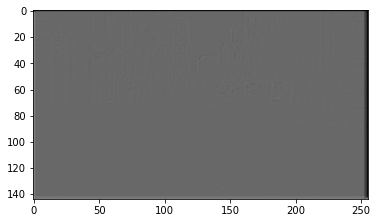

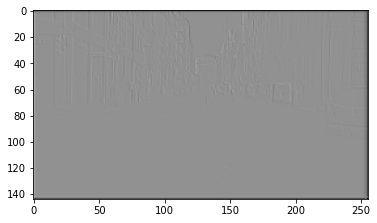

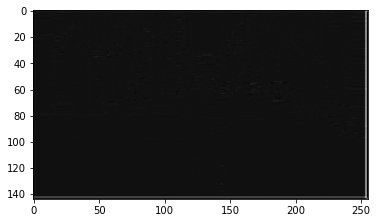

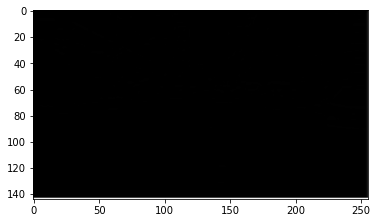

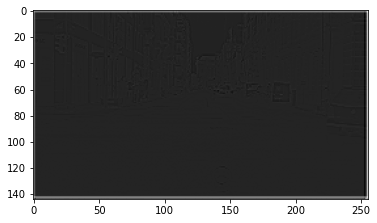

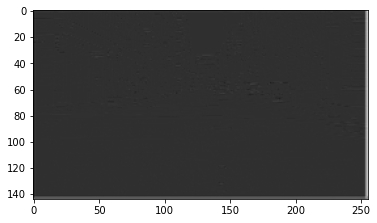

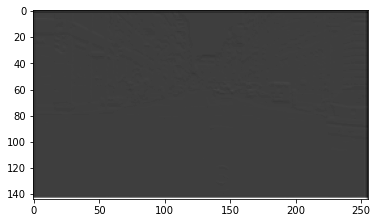

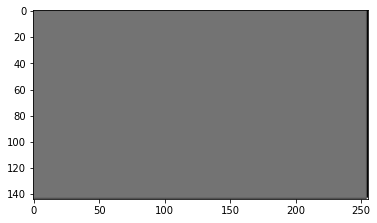

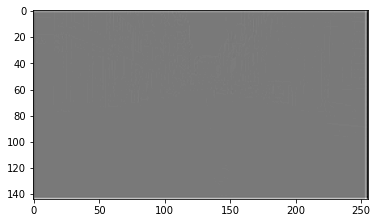

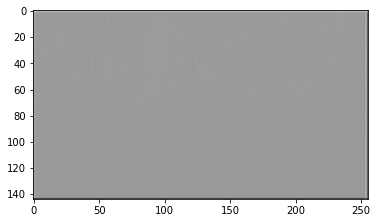

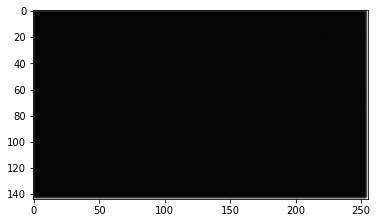

In [193]:

for i in range(len(activations[0,0,:])):
    plt.imshow(activations[:,:, i], cmap = 'gray')
    plt.show()

In [52]:
k1 = tf.io.read_file("kitti1.png")
k2 = tf.io.read_file("kitti2.png")
k3 = tf.io.read_file("kitti3.png")
k4 = tf.io.read_file("kitti4.png")

k1 = tf.io.decode_png(k1)
k2 = tf.io.decode_png(k2)
k3 = tf.io.decode_png(k3)
k4 = tf.io.decode_png(k4)

k1 = tf.cast(k1, dtype = tf.float32)/255.0
k2 = tf.cast(k2, dtype = tf.float32)/255.0
k3 = tf.cast(k3, dtype = tf.float32)/255.0
k4 = tf.cast(k4, dtype = tf.float32)/255.0

k1 = tf.image.resize(k1, (IMAGE_HEIGHT, IMAGE_WIDTH))
k2 = tf.image.resize(k2, (IMAGE_HEIGHT, IMAGE_WIDTH))
k3 = tf.image.resize(k3, (IMAGE_HEIGHT, IMAGE_WIDTH))
k4 = tf.image.resize(k4, (IMAGE_HEIGHT, IMAGE_WIDTH))

In [53]:
k1 = tf.expand_dims(k1, axis=0)
k2 = tf.expand_dims(k2, axis=0)
k3 = tf.expand_dims(k3, axis=0)
k4 = tf.expand_dims(k4, axis=0)

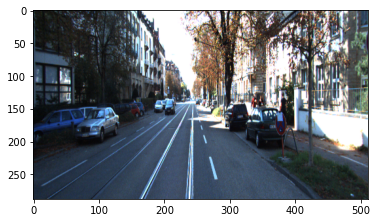

In [54]:
plt.imshow(k1[0])

In [59]:
pred1 = tf.argmax(model.predict(k1), axis = -1)
pred2 = tf.argmax(model.predict(k2), axis = -1)
pred3 = tf.argmax(model.predict(k3), axis = -1)
pred4 = tf.argmax(model.predict(k4), axis = -1)

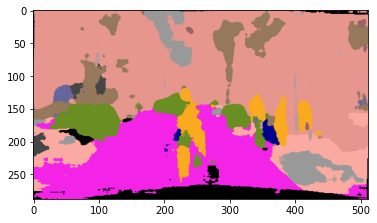

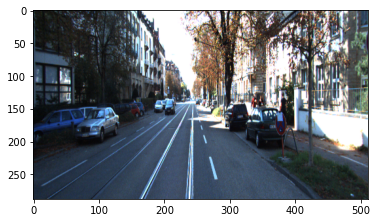

In [61]:
color_label = np.apply_along_axis(fill_color, axis = 2, arr = np.expand_dims(pred1[0], axis = 2))
plt.imshow(color_label)
plt.show()
plt.imshow(k1[0])
plt.show()

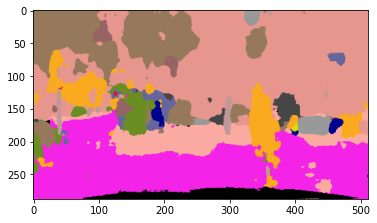

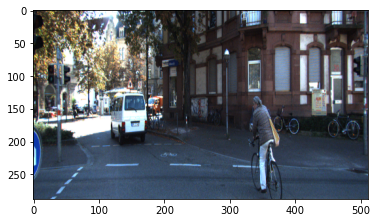

In [62]:
color_label = np.apply_along_axis(fill_color, axis = 2, arr = np.expand_dims(pred2[0], axis = 2))
plt.imshow(color_label)
plt.show()
plt.imshow(k2[0])
plt.show()

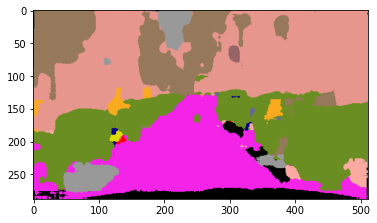

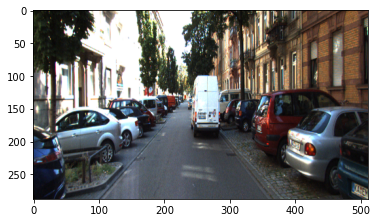

In [63]:
color_label = np.apply_along_axis(fill_color, axis = 2, arr = np.expand_dims(pred3[0], axis = 2))
plt.imshow(color_label)
plt.show()
plt.imshow(k3[0])
plt.show()

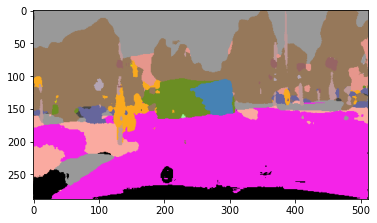

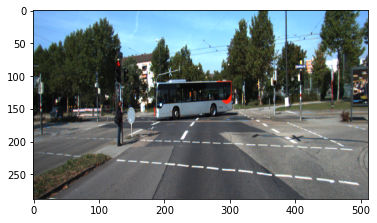

In [64]:
color_label = np.apply_along_axis(fill_color, axis = 2, arr = np.expand_dims(pred4[0], axis = 2))
plt.imshow(color_label)
plt.show()
plt.imshow(k4[0])
plt.show()